## Prepare predicted magnitude and redshift dataset

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import numpy as np
from os import environ
from pathlib import Path
from einops import rearrange
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from hydra import initialize, compose
from hydra.utils import instantiate

from bliss.surveys.dc2 import DC2
from pathlib import Path

environ["BLISS_HOME"] = str(Path().resolve().parents[2])
home = environ["BLISS_HOME"]

In [3]:
with initialize(config_path=f"../../dc2", version_base=None):
    notebook_cfg = compose("notebook_config")

### Load One Full Image

In [4]:
dc2: DC2 = instantiate(notebook_cfg.surveys.dc2)
test_sample = dc2.get_plotting_sample(0)

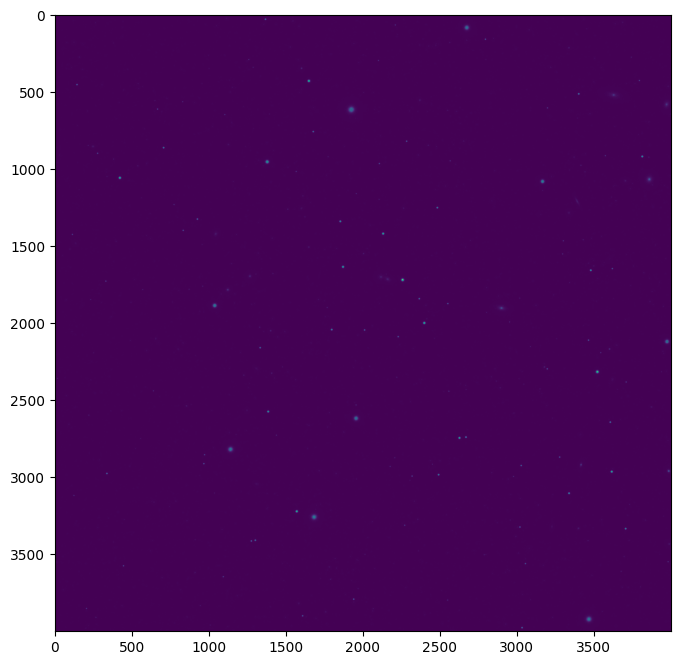

In [5]:
# full image (4000 x 4000)
fig, ax = plt.subplots(figsize=(8, 8))
image = test_sample["image"][0]
ax.imshow(np.log((image - image.min()) + 10), cmap="viridis");

In [6]:
cur_image_wcs = test_sample["wcs"]
cur_image_true_full_catalog = test_sample["full_catalog"]
cur_image_match_id = test_sample["match_id"]

### Load the trained model and make prediction

In [7]:
with open(f"{home}/case_studies/dc2/DC2_exp_output/plotting_model_output-v2.pkl", "rb") as inputp: 
    out_dict = pickle.load(inputp)

In [8]:
out_dict

{'mode_cat': TileCatalog(1 x 1000 x 1000),
 'sample_cat': TileCatalog(1 x 1000 x 1000)}

In [9]:
bliss_catalog = out_dict["mode_cat"]
bliss_catalog = bliss_catalog.to_full_catalog()
# bliss_catalog.plocs = bliss_catalog.plocs + 4
matcher = instantiate(notebook_cfg.encoder.matcher)
metrics = instantiate(notebook_cfg.encoder.metrics)
matching = matcher.match_catalogs(test_sample["full_catalog"], bliss_catalog)

### Plotting

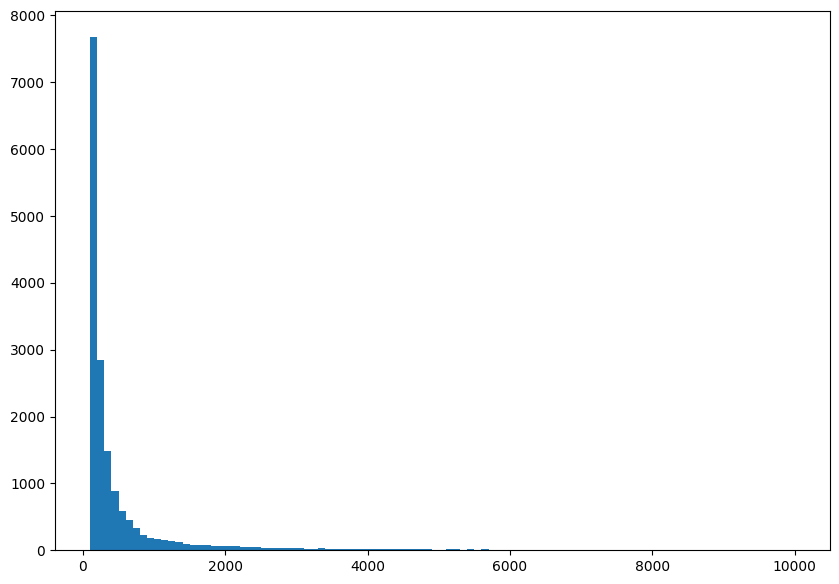

In [10]:
# galaxy flux distribution
from einops import rearrange, reduce
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import min_weight_full_bipartite_matching
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 7))
ax.hist(cur_image_true_full_catalog["galaxy_fluxes"][0, :, 2], 
        np.linspace(100, 10000, num=100));

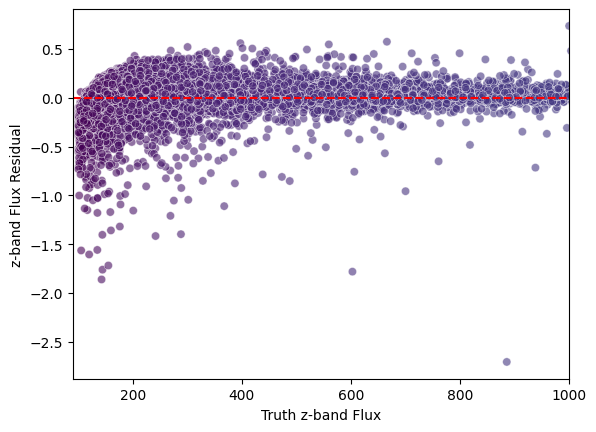

In [11]:
# flux error
true_matches, bliss_matches = matching[0]
true_flux = cur_image_true_full_catalog.on_fluxes[0, true_matches, :]
bliss_flux = bliss_catalog.on_fluxes[0, bliss_matches, :]
flux_err = true_flux - bliss_flux
est_band_flux = bliss_flux[:, 2]
true_band_flux = true_flux[:, 2]
res = flux_err[:, 2] / true_band_flux
sns.scatterplot(
    x = np.array(true_band_flux), 
    y = np.array(res), 
    alpha = 0.6,
    c = np.log(true_flux[:, 2]), 
    cmap = "viridis"
)
plt.xlim(90, 1000)
plt.ylabel('z-band Flux Residual')
plt.xlabel('Truth z-band Flux')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [12]:
# redshift
true_redshift = cur_image_true_full_catalog["redshift"][0, true_matches, :]
true_flux = cur_image_true_full_catalog.on_fluxes[0, true_matches, :]
bliss_flux = bliss_catalog.on_fluxes[0, bliss_matches, :]
bliss_flux_nmgy = bliss_flux / 3631
true_flux_nmgy = true_flux / 3631 # transform from nanojansky to nanomaggie

true_mag = 22.5 - 2.5 * torch.log10(true_flux_nmgy)
bliss_mag = 22.5 - 2.5 * torch.log10(bliss_flux_nmgy)

In [13]:
def transform_column(df):
    """tansform column name to order that meet regression model

    Args:
        df: DataFrame
    
    Returns:
        DataFrame
    """
    column_names = ['mag_g', 'mag_i', 'mag_r', 'mag_u', 'mag_y', 'mag_z', 'redshift']
    df.columns = column_names
    new_column_order = ['mag_u', 'mag_g', 'mag_r', 'mag_i', 'mag_z', 'mag_y', 'redshift']
    df = df[new_column_order]
    return df

Save bliss predicted mag & redshift

In [14]:
df_bliss = pd.DataFrame(torch.cat([bliss_mag, true_redshift], dim=1))
df_bliss = transform_column(df_bliss)


In [15]:
dataset_name = "bliss_pred_mag"
path = f"{home}/data/redshift/dc2/{dataset_name}.pkl"
df_bliss.to_pickle(path)

In [16]:
df_bliss.describe()

,mag_u,mag_g,mag_r,mag_i,mag_z,mag_y,redshift
count,14292.000000,14292.000000,14292.000000,14292.000000,14292.000000,14292.000000,14292.000000
mean,25.832241,25.427021,24.968906,24.578296,24.312630,24.142137,1.072207
std,1.400385,1.302826,1.334272,1.429313,1.474769,1.491920,0.601093
min,12.741692,11.285736,10.903307,10.618278,10.525139,10.433258,0.000000
25%,25.140152,24.937806,24.491937,23.993539,23.673376,23.475163,0.628149
50%,25.955545,25.715402,25.383568,24.967161,24.668937,24.504927,1.005365
75%,26.696719,26.220187,25.895331,25.556984,25.325114,25.166903,1.434995
max,30.090042,27.727346,26.417490,26.391552,26.369776,26.326439,3.033552


Save true mag & redshift

In [17]:
df_true = pd.DataFrame(torch.cat([true_mag, true_redshift], dim=1))
df_true = transform_column(df_true)

In [18]:
dataset_name = "bliss_true_mag"
path = f"{home}/data/redshift/dc2/{dataset_name}.pkl"
df_true.to_pickle(path)

In [19]:
df_true.describe()

,mag_u,mag_g,mag_r,mag_i,mag_z,mag_y,redshift
count,14292.000000,14292.000000,14292.000000,14292.000000,14292.000000,14292.000000,14292.000000
mean,25.898018,25.437513,24.948318,24.538420,24.253687,24.060061,1.072207
std,1.487985,1.321719,1.339990,1.431461,1.486164,1.511879,0.601093
min,13.252688,12.038526,11.554999,11.359062,11.275438,11.242414,0.000000
25%,25.131031,24.916900,24.453637,23.940647,23.585706,23.345462,0.628149
50%,25.966040,25.684349,25.343583,24.904023,24.566702,24.363010,1.005365
75%,26.762312,26.250888,25.862646,25.506156,25.268408,25.106677,1.434995
max,30.563740,28.156767,26.399584,26.627220,26.686035,26.748785,3.033552
